In [1]:
import src.data
import src.lfads_helpers
import src.util
import pyaldata
import yaml
import matplotlib.pyplot as plt
import numpy as np
from src.models import SSA
import seaborn as sns
import k3d
from sklearn.decomposition import PCA

sns.set_context('talk')

%load_ext autoreload
%autoreload 2

In [3]:
with open('../params.yaml', 'r') as params_file:
    params = yaml.safe_load(params_file)
    lfads_params = params['lfads_prep']
    analysis_params = params['dynamics_analysis']


trial_data = src.data.load_clean_data('../data/trial_data/Earl_20190716_COCST_TD.mat')
td_co = src.lfads_helpers.prep_data_with_lfads(trial_data, 'CO', lfads_params)
td_cst = src.lfads_helpers.prep_data_with_lfads(trial_data,'CST', lfads_params)

joint_pca_model = PCA(n_components=analysis_params['num_dims'])
joint_pca_model.fit(np.row_stack([np.row_stack(td_cst['lfads_rates']),np.row_stack(td_co['lfads_rates'])]))
td_co['lfads_joint_pca'] = [joint_pca_model.transform(sig) for sig in td_co['lfads_rates']]
td_cst['lfads_joint_pca'] = [joint_pca_model.transform(sig) for sig in td_cst['lfads_rates']]

co_epoch_fun = src.util.generate_realtime_epoch_fun(
    'idx_goCueTime',
    rel_start_time=-1.0,
    rel_end_time=0.5,
)
cst_epoch_fun = src.util.generate_realtime_epoch_fun(
    'idx_goCueTime',
    rel_start_time=-1.0,
    rel_end_time=5.0,
)
td_co = pyaldata.restrict_to_interval(td_co,epoch_fun=co_epoch_fun)
td_cst = pyaldata.restrict_to_interval(td_cst,epoch_fun=cst_epoch_fun)


/home/raeed/miniconda3/envs/autolfads-tf2/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [  7   8  11  18  19  22  24  25  33  34  36  56  62  66  86  92  94  95
 103 107 110 112 115 120 123 131 135 137 139 146 157 159 161 162 165 173
 179 181 187 200 218 222 224 225 229 230 237 239 241 244 249 254 261 266
 269 276 281 286 304 306 308 309 316 321 334 338 342 344 347 351 352 355
 357 360 361 363 366 370 371 373 376 378 379 381 382 384 386 388 393 394
 396 399 403 404 405 408 409 411 413 416 420 422 423 424 426 427 428 429
 431 435 436 437 445 446 447 452 454 456 458 459 460 461 462 464 469 470
 472 476 477 481 483 484 488 489 490 491 492 494 500 502 508 509 510 512
 513 516 519 534 535 536]
/home/raeed/miniconda3/envs/autolfads-tf2/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Dropping the trials with the following I

In [4]:

target_dirs = td_co['tgtDir'].unique()
dir_colors = plt.get_cmap('Dark2',8)
# fig,ax = plt.subplots()
trace_plot = k3d.plot(name='Neural Traces')
for dirnum,target_dir in enumerate(target_dirs):
    # plot traces
    color_val = int(255*dir_colors(dirnum)[0]) << 16 | int(255*dir_colors(dirnum)[1]) << 8 | int(255*dir_colors(dirnum)[2])
    td_co_dir = td_co.loc[np.isclose(td_co['tgtDir'],target_dir)]
    for _,trial in td_co_dir.sample(n=25).iterrows():
        neural_trace = trial['lfads_joint_pca']
        #trace_plot+=k3d.line(neural_trace[:,0:3].astype(np.float32),shader='mesh',width=0.2,color=color_val)
        trace_plot+=k3d.line(neural_trace[:,0:3].astype(np.float32),shader='mesh',width=0.2,attribute=trial['hand_vel'][:,0],color_map=k3d.matplotlib_color_maps.PiYG)
    
    #trace_plot+=k3d.line(td_co_dir['lfads_joint_pca'].mean()[:,0:3].astype(np.float32),shader='mesh',width=1,color=color_val)

# fig,ax = plt.subplots()
# trace_plot = k3d.plot(name='Neural Traces')
# plot traces
for _,trial in td_cst.sample(n=10).iterrows():
    neural_trace = trial['lfads_joint_pca']
    trace_plot+=k3d.line(neural_trace[:,0:3].astype(np.float32),shader='mesh',width=0.2,attribute=trial['hand_vel'][:,0],color_map=k3d.matplotlib_color_maps.PiYG)

# trace_plot+=k3d.line(td_cst['M1_pca'].mean()[:,0:3].astype(np.float32),shader='mesh',width=1,color=0)

trace_plot.display()

Output()

In [6]:
# load SSA model
# ssa_model = SSA()
# ssa_model.load_model_from_file('../results/ssa/Earl_20190716_CST_lfads_ssa_model.pt')
ssa_model = SSA(R=15,n_epochs=3000,lr=0.01)
td_cst = pyaldata.dim_reduce(td_cst,ssa_model,'lfads_rates','lfads_ssa')
td_co['lfads_ssa'] = [ssa_model.transform(sig) for sig in td_co['lfads_rates']]
td_cst['lfads_ssa'] = [ssa_model.transform(sig) for sig in td_cst['lfads_rates']]

Using lam_sparse=  0.08356205044121653
Using device cuda:0


100%|██████████| 3000/3000 [00:27<00:00, 110.46it/s]


In [7]:
def plot_trial(trial_to_plot,ax_list,signal_to_plot):
    num_dims = ax_list.shape[0]-1

    beh_ax = ax_list[-1]
    beh_ax.plot(trial_to_plot['trialtime'][[0,-1]],[0,0],color='k')
    beh_ax.plot(trial_to_plot['trialtime'],trial_to_plot['rel_hand_pos'][:,0],'r')
    beh_ax.plot(trial_to_plot['trialtime'],trial_to_plot['rel_cursor_pos'][:,0],'b')
    beh_ax.set_yticks([])
    beh_ax.set_ylim([-50,50])
    beh_ax.set_xlabel('Time')
    beh_ax.plot([0,0],beh_ax.get_ylim(),color='k',linestyle='--')

    for i in range(num_dims):
        ax = ax_list[i]
        # Plot SSA results
        ax.plot(trial_to_plot['trialtime'][[0,-1]],[0,0],color='k')
        ax.plot(trial_to_plot['trialtime'],trial_to_plot[signal_to_plot][:,i])
        ax.set_yticks([])
        ax.plot([0,0],ax.get_ylim(),color='k',linestyle='--')
        ax.sharex(beh_ax)


In [8]:
from ipywidgets import interact
# plot out SSA projections and hand/cursor movement
td_co = src.data.add_trial_time(td_co,ref_event='idx_goCueTime')
td_cst = src.data.add_trial_time(td_cst,ref_event='idx_goCueTime')
num_dims = ssa_model.ssa_params['R']

@interact(cst_trial_id = list(td_cst['trial_id']),co_trial_id = list(td_co['trial_id']))
def plot_trial_ssa(cst_trial_id,co_trial_id):
    cst_trial = td_cst.loc[td_cst['trial_id']==cst_trial_id,:].squeeze()
    co_trial = td_co.loc[td_co['trial_id']==co_trial_id,:].squeeze()
    fig,axs = plt.subplots(num_dims+1,2,figsize=(10,10))

    plot_trial(cst_trial,axs[:,0],'lfads_ssa')
    plot_trial(co_trial,axs[:,1],'lfads_ssa')
    for i in range(num_dims+1):
        axs[i,0].set_ylabel('{}'.format(i))
        axs[i,1].sharey(axs[i,0])

    axs[num_dims,0].set_ylabel('Beh')

    axs[0,0].set_title(f"CST (lam={cst_trial['lambda']})")
    axs[0,1].set_title(f"CO (dir={co_trial['tgtDir']}, mag={co_trial['tgtMag']})")

    sns.despine(fig=fig,left=True,bottom=True,trim=True)


interactive(children=(Dropdown(description='cst_trial_id', options=(2, 3, 4, 5, 6, 9, 10, 12, 13, 14, 15, 20, …

In [9]:
td_co_avg = pyaldata.trial_average(td_co,condition=None)
td_cst_avg = pyaldata.trial_average(td_cst,condition=None)

/home/raeed/codebase/professional/pyaldata/pyaldata/tools.py:217: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  av_df = trial_data.mean()
/home/raeed/codebase/professional/pyaldata/pyaldata/tools.py:217: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  av_df = trial_data.mean()
/home/raeed/codebase/professional/pyaldata/pyaldata/tools.py:217: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  av_df = trial_data.mean()
/home/raeed/codebase/professional/pyaldata/pyaldata/tools.py:217: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise Type

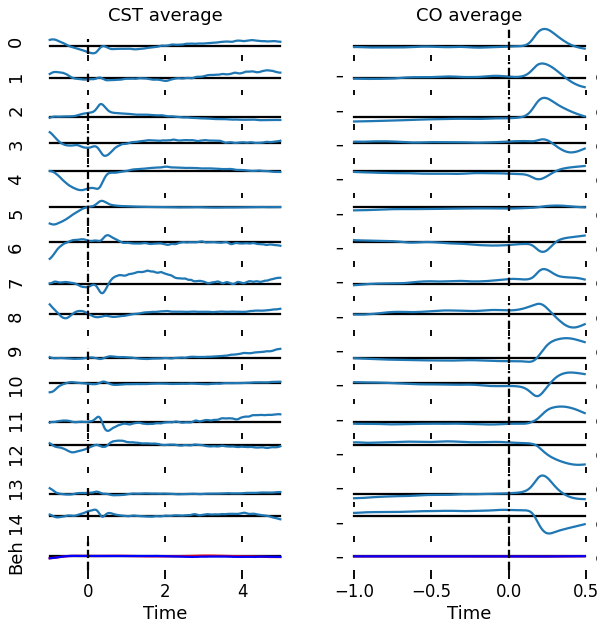

In [10]:
fig_avg,axs_avg = plt.subplots(num_dims+1,2,figsize=(10,10))

plot_trial(td_cst_avg,axs_avg[:,0],'lfads_ssa')
plot_trial(td_co_avg,axs_avg[:,1],'lfads_ssa')
for i in range(num_dims+1):
    axs_avg[i,0].set_ylabel('{}'.format(i))
    axs_avg[i,1].sharey(axs_avg[i,0])

axs_avg[num_dims,0].set_ylabel('Beh')

axs_avg[0,0].set_title(f"CST average")
axs_avg[0,1].set_title(f"CO average")
sns.despine(fig=fig_avg,left=True,bottom=True,trim=True)
